    #  Width has to b modified by cos(pi/4)

In [1]:
using PyPlot
using FileIO
using ImageMagick
using ImageIO
using Colors 
using HDF5
using Distributions
using JLD2
using FileIO
using Statistics
using StatsBase 
using LinearAlgebra
using IntervalSets
using Random
using ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using BAT 
using DSP
using SpecialFunctions
using Random123

In [2]:
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [4]:
# Pixel Size used in MCMC analysis: 
    
values_mcmc = (    
    BTV50 = [0.0271,  0.0305],
    BTV53 = [0.0216, 0.0234],
    BTV26 = [0.114, 0.125],
    IS2 = [0.0303, 0.0298], # times 3 
)

(BTV50 = [0.0271, 0.0305], BTV53 = [0.0216, 0.0234], BTV26 = [0.114, 0.125], IS2 = [0.0303, 0.0298])

## Functions: 

In [5]:
# Functions: 

function analyt_conv(x, res, start, stop) 
    return 0.5*(erf((x-start)/res/sqrt(2)) - erf((x-stop)/res/sqrt(2)))
end

function log_likelihood(parms, data)
    
    n_pixels = length(data[1,:])
    edges = range(0, step = parms.pixel_size, length = n_pixels)
    
    step_start = parms.frame_start*parms.pixel_size
    step_stop = step_start + parms.frame_width
    
    conv_run(x) = analyt_conv(x, parms.sigma_resolution * parms.pixel_size, step_start, step_stop)
    
    signal = conv_run.(edges)
    signal += parms.ped .+ parms.slope .* edges
    signal = signal .*  parms.intens
    
    ll = 0.0 
    for data_ind in 1:size(data)[1]
        data_row = data[data_ind,:]
        ll += sum(logpdf.(Normal.(signal, parms.fluct), data_row))
    end
    
    return LogDVal(ll)
end


function ll_reconstruct(parms, data)
    
    n_pixels = length(data[1,:])
    edges = range(0, step = parms.pixel_size, length = n_pixels)
    
    step_start = parms.frame_start*parms.pixel_size
    step_stop = step_start + parms.frame_width
    
    conv_run(x) = analyt_conv(x, parms.sigma_resolution * parms.pixel_size, step_start, step_stop)
    
    signal = conv_run.(edges)
    signal += parms.ped .+ parms.slope .* edges
    signal = signal .*  parms.intens
    
    return edges, signal
end


ll_reconstruct (generic function with 1 method)

In [6]:
tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

mcmcalgo = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = tuning
)

rng = Philox4x()

init = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1500
)

burnin = MCMCMultiCycleBurnin(
    max_ncycles = 160,
    nsteps_per_cycle = 40000
)

nsamples = 5*10^5
nchains = 4

convergence = BrooksGelmanConvergence(threshold=1.15);

algorithm = MCMCSampling(
        mcalg = mcmcalgo,
        trafo = NoDensityTransform(),
        nchains = nchains,
        nsteps = nsamples,
        init = init,
        burnin = burnin,
        convergence = convergence,
        strict = false,
#         store_burnin = false,
#         nonzero_weights = true,
)

MCMCSampling{MetropolisHastings{BAT.MvTDistProposal,RepetitionWeighting{Int64},AdaptiveMHTuning},NoDensityTransform,MCMCChainPoolInit,MCMCMultiCycleBurnin,BrooksGelmanConvergence,typeof(BAT.nop_func)}
  mcalg: MetropolisHastings{BAT.MvTDistProposal,RepetitionWeighting{Int64},AdaptiveMHTuning}
  trafo: NoDensityTransform NoDensityTransform()
  nchains: Int64 4
  nsteps: Int64 500000
  init: MCMCChainPoolInit
  burnin: MCMCMultiCycleBurnin
  convergence: BrooksGelmanConvergence
  strict: Bool false
  store_burnin: Bool false
  nonzero_weights: Bool true
  callback: nop_func (function of type typeof(BAT.nop_func))


# <center> Camera #1 (BTV 50) </center>

## Region 4: 

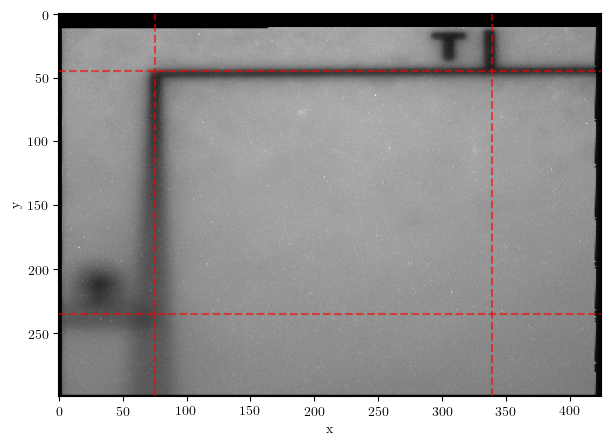

PyObject Text(22.299550986642977, 0.5, 'y')

In [7]:
img_path = "../data/resolution/2018_10_17/TT41.BTV412350_S1_F75_T.png"
img = Gray.(load(img_path))
img_y = convert(Array{Float64},img)

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img_y, cmap="gray")

start = (x = 75, y = 235)
stop = (x = 339, y = 45)

ax.axhline(start.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(stop.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(start.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(stop.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.set_xlabel("x")
ax.set_ylabel("y")

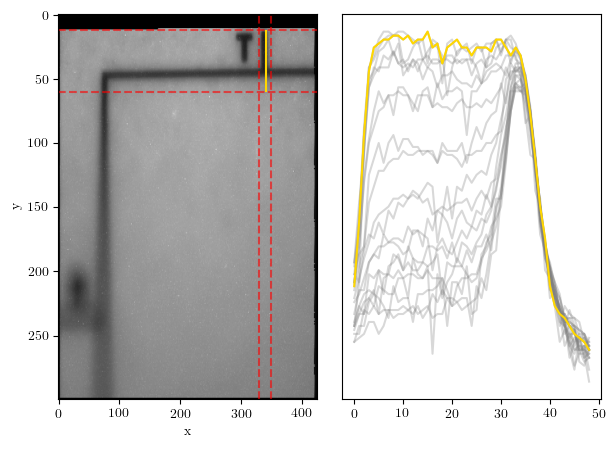

PyObject Text(22.299550986642977, 0.5, 'y')

In [8]:


pr_ind = 11 # 9:11

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")


frame = (x = [330, 350], y = [12,60])

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+pr_ind, frame.y[1], frame.y[2], color="gold")

selected_region = img_y[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)
selected_region = selected_region'

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

ax2.plot(selected_region[pr_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [9]:
data_vector = selected_region[9:11,:]

width_tmp = ((20 - 16.97 ) / 2)*cos(pi/4)

prior = NamedTupleDist(
    frame_width = Normal(width_tmp, 0.05*width_tmp), # [mm] ticknes of the line
    pixel_size = Normal(0.0305, 0.02*0.0305), # [mm] 
    frame_start = 1 .. 35, # pixel #
    sigma_resolution = 0 .. 8, # [pixels]
    intens = 0 .. 1, # [a.u.]
    ped = -2 .. 2,
    fluct = 0.001 .. 2,
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

In [10]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

Figure(PyObject <Figure size 1000x1000 with 49 Axes>)

In [11]:
mean(samples)[1]

(frame_width = 1.1022018046639215, pixel_size = 0.030354019442579608, frame_start = 1.454323759486578, sigma_resolution = 1.9112457289800269, intens = 0.2703272179661588, ped = 0.25817299838750696, fluct = 0.01245515866269881, slope = -0.055576827727896565)

In [12]:
1.91*0.0305

0.058254999999999994

In [13]:
0.1*0.0305

0.00305

In [14]:
std(samples)[1]

(frame_width = 0.02101153376979021, pixel_size = 0.0005689850136743155, frame_start = 0.11452645554926665, sigma_resolution = 0.09646481013906048, intens = 0.004902914923794117, ped = 0.030279315261011113, fluct = 0.0007499894341720479, slope = 0.018157216330162585)

In [15]:
sig_tmp = samples.v.pixel_size .* samples.v.sigma_resolution

mean(sig_tmp, FrequencyWeights(samples.weight)), std(sig_tmp, FrequencyWeights(samples.weight))

(0.05801395528245493, 0.0031235857874166934)

In [16]:
0.0580 / 0.0271

2.1402214022140225

In [17]:
par_test = mode(samples)[1]
edges, prediction_vect = ll_reconstruct(par_test, data_vector);

In [18]:
dt_comb_1 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.11372549019607842 0.16470588235294115 … 0.047058823529411764 0.03137254901960784; 0.11764705882352938 0.1764705882352941 … 0.039215686274509776 0.03137254901960784; 0.09411764705882353 0.1568627450980392 … 0.039215686274509776 0.03137254901960784], predvec = [0.12854170735198686, 0.17793221085920882, 0.23400396692354364, 0.28226340200970357, 0.3137123179102496, 0.32913795389884126, 0.33469505540768624, 0.3359773302216495, 0.3359134486030317, 0.3355363760238642  …  0.12132219238379219, 0.0834873586720403, 0.06280456852410796, 0.05403980230809672, 0.050999645815441044, 0.049943336731951136, 0.049392963263421734, 0.04893856035211027, 0.04849778326047611, 0.04805845983758822])

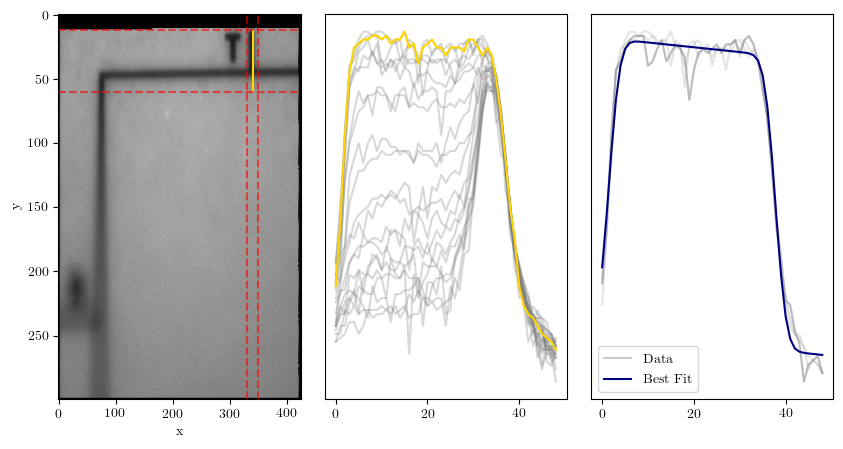

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


PyObject Text(22.299550986642977, 0.5, 'y')

In [19]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+pr_ind, frame.y[1], frame.y[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end
ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[pr_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[pr_ind,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

***

In [20]:
# sigma x: 3.29 | 3.03 
# sigma y: 2.40 | 1.89

# <center> Camera #2 (BTV 53) <center>

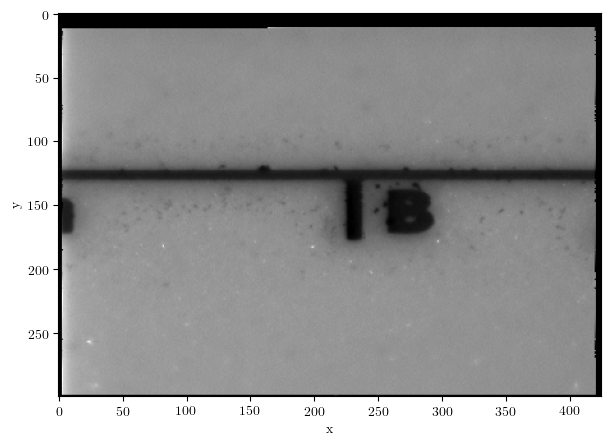

PyObject Text(22.299550986642977, 0.5, 'y')

In [21]:
img_path = "../data/resolution/2018_10_17/TT41.BTV412353_S1_F75.png"
img = Gray.(load(img_path))
img_y = convert(Array{Float64},img)

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img_y, cmap="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")

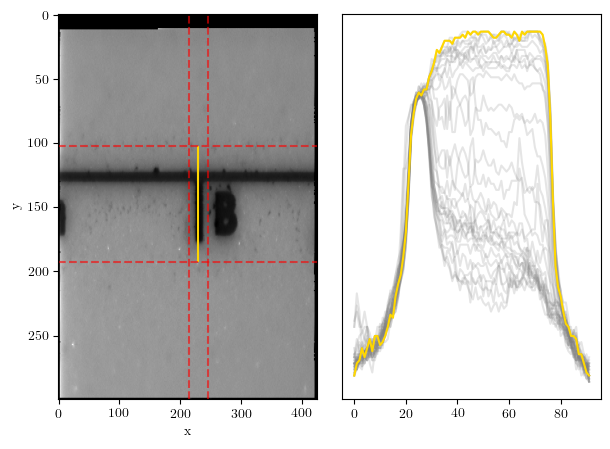

PyObject Text(22.299550986642977, 0.5, 'y')

In [22]:
frame = (x = [215, 245], y = [102,193])
fr_ind = 15
fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+fr_ind, frame.y[1], frame.y[2], color="gold")

selected_region = img_y[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)
selected_region = selected_region'
for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.2)
end

ax2.plot(selected_region[fr_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [23]:
data_vector = selected_region[15:17,:]

width_tmp = ((20 - 16.97 ) / 2)*cos(pi/4)

prior = NamedTupleDist(
    frame_width = Normal(width_tmp, 0.05*width_tmp), # [mm] ticknes of the line
    pixel_size = Normal(0.0234, 0.02*0.0234), # [mm]
    frame_start = 2 .. 40, # pixel #
    sigma_resolution = 0 .. 15, # [pixels]
    intens = 0 .. 1, # [a.u.]
    ped = -2 .. 2,
    fluct = 0.001 .. 2,
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

In [24]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /user/.julia/packages/PyCall/tqyST/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6340, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 816, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1430, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1501, in _contour_args
    self._process_contour_level_args(args)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1172, in _process_contour_level_args
    raise ValueError("Contour levels must be increasing")


In [25]:
mean(samples)[1]

(frame_width = 1.275489575199915, pixel_size = 0.022504354087602027, frame_start = 20.663609274469785, sigma_resolution = 3.105700874288082, intens = 0.3926149811343192, ped = 0.10859023032524874, fluct = 0.022209560381341437, slope = 0.008374396133832255)

In [26]:
std(samples)[1]

(frame_width = 0.023893636006712425, pixel_size = 0.00041889423911658434, frame_start = 0.13804207455831527, sigma_resolution = 0.1597371777230769, intens = 0.003787337843776892, ped = 0.009523564781405309, fluct = 0.0009596547446195161, slope = 0.0070009845372635505)

In [27]:
2.11*23.4

49.373999999999995

In [28]:
0.16*23.4

3.7439999999999998

In [29]:
par_test = mode(samples)[1]
edges, prediction_vect = ll_reconstruct(par_test, data_vector);

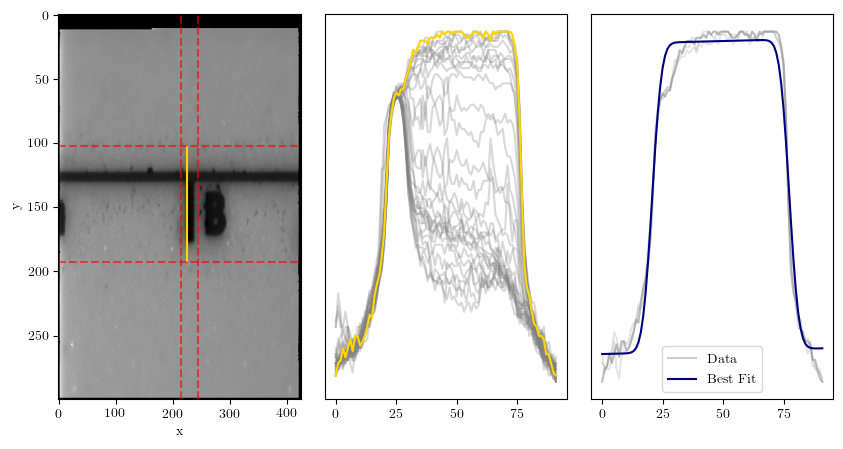

PyObject Text(22.299550986642977, 0.5, 'y')

In [30]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img_y, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.vlines(frame.x[1]+pr_ind, frame.y[1], frame.y[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end
ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[pr_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[15,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [31]:
dt_comb_2 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.007843137254901988 0.02352941176470591 … 0.011764705882352955 0.007843137254901988; 0.0431372549019608 0.019607843137254888 … 0.02352941176470591 0.007843137254901988; 0.03137254901960784 0.027450980392156876 … 0.019607843137254888 0.011764705882352955], predvec = [0.0427556921857067, 0.04283526281869497, 0.042914833748133575, 0.042994406652380295, 0.04307399140270747, 0.043153640121576506, 0.04323359968119595, 0.043314917842645594, 0.043401574116841396, 0.043507072312853556  …  0.07545439545686787, 0.0627788629057873, 0.055724463894996745, 0.05220291102920442, 0.05064188576184135, 0.050046898713667555, 0.0498761542106138, 0.049871894337164525, 0.04992612767030999, 0.04999878701973271])

In [32]:
# res x: 3.4229 | 3.73
# res y: 3.83 | 3.079

***

# Camera #3 (BTV 26): 

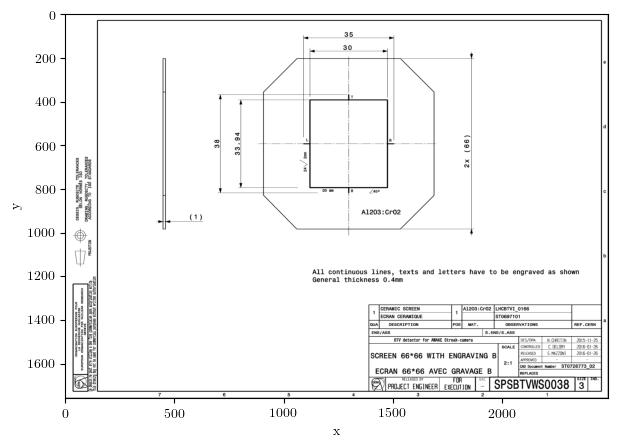

PyObject Text(22.299550986642977, 0.5, 'y')

In [33]:
img_path = "../data/resolution/Screen_BTV-26-is2.png"
img = Gray.(load(img_path))
img_frame = convert(Array{Float64},img);

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img_frame, cmap="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")

## Image 1: 

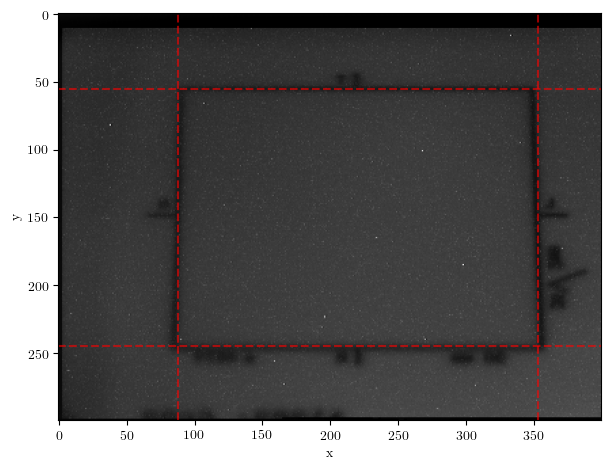

dx = 30.0 / (stop.x - start.x) = 0.11320754716981132
dy = (33.94 * cos(pi / 4)) / abs(stop.y - start.y) = 0.12631160080774434


0.12631160080774434

In [34]:
fid = h5open("../data/resolution/calib-data.h5", "r") do file
    read(file, "btv26")
    end;

img = convert.(Float64, fid)'

fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img, cmap="gray")

start = (x = 88, y = 245)
stop = (x = 353, y = 55)

ax.axhline(start.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(stop.y, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(start.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(stop.x, linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.set_xlabel("x")
ax.set_ylabel("y")


@show dx = 30.0/(stop.x - start.x) # mm/pixel
@show dy = (33.94)*cos(pi/4) / abs((stop.y - start.y))

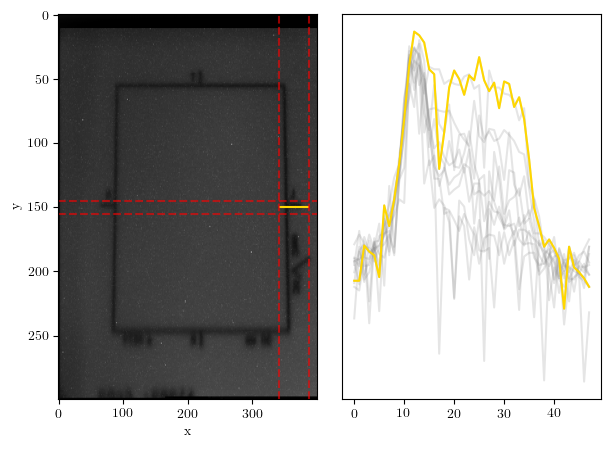

PyObject Text(22.299550986642977, 0.5, 'y')

In [35]:
frame = (x = [341, 388], y = [145,155])

tmp_ind = 5 # 5:6

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

selected_region = img[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.2)
end

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [36]:
data_vector = selected_region[5:6,:]
data_vector = data_vector ./ maximum(data_vector)

fwidth = (35-30) / 2
prior = NamedTupleDist(
    frame_width = Normal(fwidth, 0.05*fwidth), # [mm] ticknes of the line
    pixel_size = Normal(0.114, 0.02*0.114), # [mm] 
    frame_start = 2 .. 20, # pixel #
    sigma_resolution = 0.0001 .. 15, # [pixels]
    intens = 0 .. 5, # [a.u.]
    ped = -2 .. 2,
    fluct = 0.001 .. 2, 
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

In [37]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

Figure(PyObject <Figure size 1000x1000 with 49 Axes>)

In [38]:
mean(samples)[1]

(frame_width = 2.9173819660084623, pixel_size = 0.1103432175772536, frame_start = 8.815313025667002, sigma_resolution = 1.7621737402571727, intens = 0.5060890100376125, ped = 0.75203459781081, fluct = 0.062025055169137665, slope = -0.02357673762306937)

In [39]:
std(samples)[1]

(frame_width = 0.06285281298496216, pixel_size = 0.002093190982718155, frame_start = 0.2506209831775376, sigma_resolution = 0.24906478939633647, intens = 0.01624019026035926, ped = 0.055999073142201795, fluct = 0.004739409361145978, slope = 0.009811163808253337)

In [40]:
1.76*114

200.64000000000001

In [41]:
0.25*114

28.5

In [42]:
par_test = mode(samples)[1]

edges, prediction_vect = ll_reconstruct(par_test, data_vector);

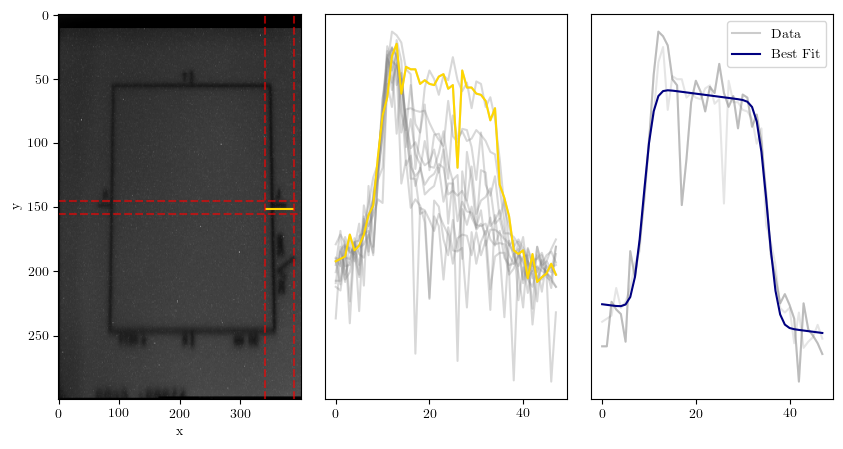

PyObject Text(22.299550986642977, 0.5, 'y')

In [43]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

tmp_ind = 6
 
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end

ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[tmp_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [44]:
dt_comb_3 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.2881944444444444 0.2881944444444444 … 0.2951388888888889 0.2708333333333333; 0.34375 0.3506944444444444 … 0.3368055555555556 0.3055555555555556], predvec = [0.3833837305122587, 0.38200151619068196, 0.3806337842377378, 0.3794009439291977, 0.37905655459506465, 0.38282025959558813, 0.3997467370028387, 0.4451518670628252, 0.5296790885252586, 0.6416636800192231  …  0.36020081990765596, 0.3373433138280737, 0.32962088392522493, 0.3268937116091276, 0.3253058469542995, 0.32390014042410414, 0.32251501153343237, 0.3211315326006199, 0.3197481478293991, 0.31836476688921145])

## Camera #4 (IS2): (updated images)

In [45]:
using MAT

In [46]:
file = matopen("../data/resolution/is_calibr/BOVWA_02TCC4_AWAKECAM02_2020_11_02_10_58_33.mat")
img_is_1 = read(file, "data_struct") 

# img_is_1 = matread("../data/resolution/is_calibr/BOVWA_02TCC4_AWAKECAM02_2020_11_02_10_57_59.mat")
img = img_is_1["image"];

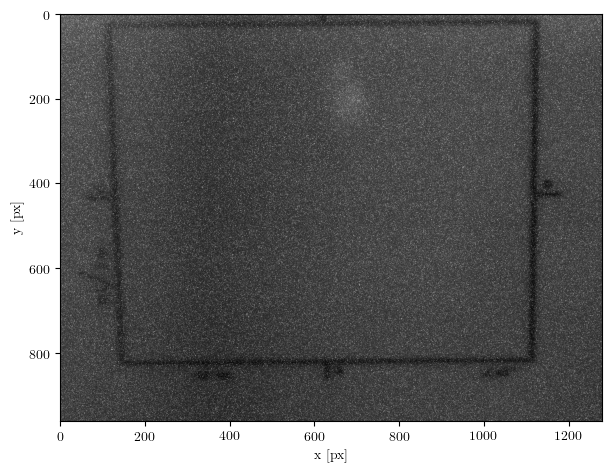

PyObject Text(23.83700013837001, 0.5, 'y [px]')

In [47]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(img, cmap="gray")

ax.set_xlabel("x [px]")
ax.set_ylabel("y [px]")


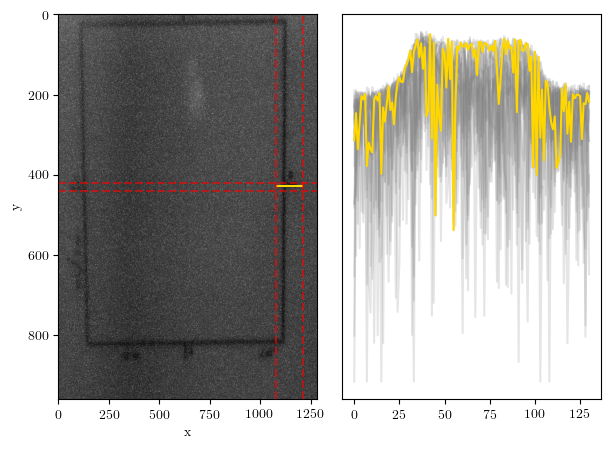

PyObject Text(22.299550986642977, 0.5, 'y')

In [48]:
frame = (x = [1080, 1210], y = [420,440])

tmp_ind = 8 # 4:8

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

selected_region = img[frame.y[1]:frame.y[2], frame.x[1]:frame.x[2]]
selected_region = minimum(selected_region) .- selected_region
selected_region = selected_region .- minimum(selected_region)

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.2)
end

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [49]:
data_vector = [mean(selected_region[4:8,:] , dims=1)[1,:]'; mean(selected_region[8:11,:] , dims=1)[1,:]']  #selected_region[4:8,:]
data_vector = data_vector ./ maximum(data_vector)

fwidth = (45-40) / 2
prior = NamedTupleDist(
    frame_width = Normal(fwidth, 0.05*fwidth), # [mm] ticknes of the line
    pixel_size = Normal(0.0406, 0.02*0.0406), # [mm] 
    frame_start = 2 .. 50, # pixel #
    sigma_resolution = 0.0001 .. 15, # [pixels]
    intens = 0 .. 5, # [a.u.]
    ped = -2 .. 20,
    fluct = 0.001 .. 2, 
    slope = -1 .. 1,
)

log_lik(x) = log_likelihood(x, data_vector)

posterior = PosteriorDensity(log_lik, prior);

samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conv

In [50]:
dims = [1,2,3,4,5,6,7,]
names = ["delta", "ps", "f_pos", "res", "intens", "ped", "fluct", "slope"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

Figure(PyObject <Figure size 1000x1000 with 49 Axes>)

In [51]:
mean(samples)[1]

(frame_width = 2.905855168485805, pixel_size = 0.03932150539850145, frame_start = 26.434378930885746, sigma_resolution = 6.926041100008681, intens = 0.16028526913427849, ped = 4.635953671988238, fluct = 0.06132353183036124, slope = 0.0316553252286516)

In [52]:
std(samples)[1]

(frame_width = 0.08456508732401664, pixel_size = 0.0007705330146087972, frame_start = 1.6248338321991123, sigma_resolution = 1.5199988474773771, intens = 0.010700748544875184, ped = 0.3590439557987312, fluct = 0.0027732538290526636, slope = 0.020099294407905192)

In [53]:
6.97*40.6

282.982

In [54]:
1.54*40.6

62.524

In [55]:
par_test = mode(samples)[1]

edges, prediction_vect = ll_reconstruct(par_test, data_vector);

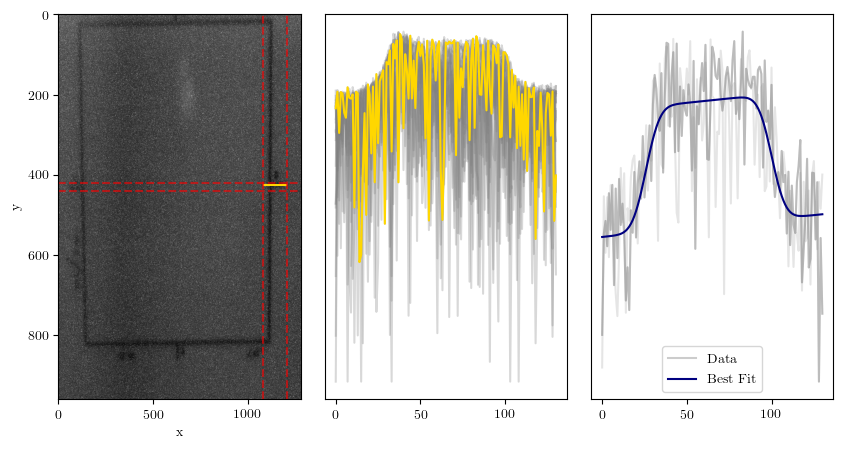

PyObject Text(22.299550986642977, 0.5, 'y')

In [56]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

tmp_ind = 6
 
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax.imshow(img, cmap="gray", aspect="auto")

ax.axhline(frame.y[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axhline(frame.y[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.axvline(frame.x[1], linestyle="dashed", color="red", lw=1.5, alpha=0.6)
ax.axvline(frame.x[2], linestyle="dashed", color="red", lw=1.5, alpha=0.6)

ax.hlines(frame.y[1]+tmp_ind, frame.x[1], frame.x[2], color="gold")

for i in eachrow(selected_region)
    ax2.plot(i, color="gray", alpha=0.3)
end

for i in eachrow(data_vector)
    ax3.plot(i, color="gray", "-", alpha=0.2)
end

ax3.plot(data_vector[1,:], color="gray", "-", alpha=0.4, label="Data")
ax3.plot(prediction_vect, color="navy", label="Best Fit")
# ax3.plot(selected_region[tmp_ind,:], color="gold", label="Example Data", alpha=1)
ax3.legend()

ax2.plot(selected_region[tmp_ind,:], color="gold", alpha=1)
ax2.set_yticks([])
ax3.set_yticks([])

ax.set_xlabel("x")
ax.set_ylabel("y")

In [57]:
dt_comb_4 = (dtvec=data_vector, predvec=prediction_vect)

(dtvec = [0.6106662479719475 0.7406186214476369 … 0.7350185795781651 0.6378290678808813; 0.5687051865808342 0.7885853352174595 … 0.7725571779975925 0.8164547024650651], predvec = [0.736308483193153, 0.7365367818031944, 0.7367682916913249, 0.7370053843748026, 0.7372519326605438, 0.7375140808683008, 0.7378012944336191, 0.7381277232239086, 0.7385138778390341, 0.7389885596640801  …  0.763553495280503, 0.7637392313589104, 0.7639409640735025, 0.7641524060400904, 0.7643695883103985, 0.7645900768967853, 0.7648124210412853, 0.7650357799820531, 0.7652596798076683, 0.765483860625909])

# Summary: 

In [58]:
# Resolution: 

cam_1 = (x = 2.0, y = 2.0, σx = 1.0, σy = 1.0)
cam_2 = (x = 3.0, y = 3.0, σx = 1.0, σy = 1.0)
cam_3 = (x = 2.0, y = 2.0, σx = 1.0, σy = 1.0) 
cam_4 = (x = 6.5, y = 6.5, σx = 2.0, σy = 2.0)

(x = 6.5, y = 6.5, σx = 2.0, σy = 2.0)

In [59]:
img_path = "../data/resolution/2018_10_17/TT41.BTV412350_S1_F75_T.png"
img = Gray.(load(img_path))
img_1 = convert(Array{Float64},img)

img_path = "../data/resolution/2018_10_17/TT41.BTV412353_S1_F75.png"
img = Gray.(load(img_path))
img_2 = convert(Array{Float64},img)

fid = h5open("../data/resolution/calib-data.h5", "r") do file
    read(file, "btv26")
    end;
img_3 = convert.(Float64, fid)'

file = matopen("../data/resolution/is_calibr/BOVWA_02TCC4_AWAKECAM02_2020_11_02_10_58_33.mat")
img_is_1 = read(file, "data_struct") 
img_4 = img_is_1["image"];

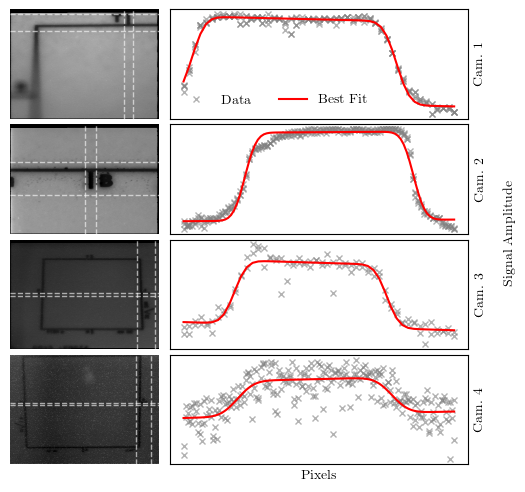

In [61]:
fig, ax = plt.subplots(4,2, figsize=(5.905631659056317, 5.905631659056317), gridspec_kw=Dict("width_ratios"=> [1,2]))

fig.subplots_adjust(hspace=0.05, wspace=0.05)

ax[1,1].pcolormesh(img_1, cmap="gray", shading="gouraud") #shading="gouraud"
ax[2,1].pcolormesh(img_2, cmap="gray", shading="gouraud")
ax[3,1].pcolormesh(img_3, cmap="gray", shading="gouraud")
ax[4,1].pcolormesh(img_4, cmap="gray", shading="gouraud")

ax[1,1].invert_yaxis()
ax[2,1].invert_yaxis()
ax[3,1].invert_yaxis()
ax[4,1].invert_yaxis()

ax[1,1].set_axis_off()
ax[2,1].set_axis_off()
ax[3,1].set_axis_off()
ax[4,1].set_axis_off()

ax[1,2].set_yticks([])
ax[2,2].set_yticks([])
ax[3,2].set_yticks([])
ax[4,2].set_yticks([])

ax[1,2].set_xticks([])
ax[2,2].set_xticks([])
ax[3,2].set_xticks([])
ax[4,2].set_xticks([])


frame = (x = [325, 350], y = [12,60])
ax[1,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[1,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[1,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[1,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

frame = (x = [215, 245], y = [102,193])
ax[2,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[2,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[2,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[2,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

frame = (x = [341, 388], y = [145,155])
ax[3,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[3,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[3,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[3,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

frame = (x = [1080, 1210], y = [420,440])
ax[4,1].axhline(frame.y[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[4,1].axhline(frame.y[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[4,1].axvline(frame.x[1], linestyle="dashed", color="white", lw=1.0, alpha=0.6)
ax[4,1].axvline(frame.x[2], linestyle="dashed", color="white", lw=1.0, alpha=0.6)

for i in eachrow(dt_comb_1.dtvec)
    ax[1,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end
ax[1,2].plot(dt_comb_1.dtvec[1,:], color="gray", "x", ms=4, alpha=0.6, label="Data")


for i in eachrow(dt_comb_2.dtvec)
    ax[2,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end

for i in eachrow(dt_comb_3.dtvec)
    ax[3,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end

for i in eachrow(dt_comb_4.dtvec)
    ax[4,2].plot(i, color="gray", "x", ms=4, alpha=0.6)
end

ax[1,2].plot(dt_comb_1.predvec, color="red", label="Best Fit")
ax[2,2].plot(dt_comb_2.predvec, color="red", label="Best Fit")
ax[3,2].plot(dt_comb_3.predvec, color="red", label="Best Fit")
ax[4,2].plot(dt_comb_4.predvec, color="red", label="Best Fit")

ax[1,2].legend(ncol=2, loc="lower left", framealpha=0.0)

ax[4,2].set_xlabel("Pixels")
ax[4,2].set_ylabel("Cam. 4")
ax[3,2].set_ylabel("Cam. 3")
ax[2,2].set_ylabel("Cam. 2")
ax[1,2].set_ylabel("Cam. 1")
ax[4,2].yaxis.set_label_position("right")
ax[4,2].yaxis.tick_right()
ax[3,2].yaxis.set_label_position("right")
ax[3,2].yaxis.tick_right()
ax[2,2].yaxis.set_label_position("right")
ax[2,2].yaxis.tick_right()
ax[1,2].yaxis.set_label_position("right")
ax[1,2].yaxis.tick_right()

fig.text(0.96, 0.5, "Signal Amplitude", va="center", rotation="vertical")

# fig.savefig("../plots/resolution-example.png", bbox_inches = "tight", dpi=350)